In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import logging

logging.getLogger().setLevel(logging.INFO)

g_figsize = (20,15)
g_title_fontsize = 30


# add the checkout rows for customers who dont have a checkout timestamp
def add_missing_checkouts(df, checkout_label = 'checkout') :
    add_rows = df.groupby('customer_no').filter(lambda x : all(x['location'] != 'checkout')).groupby('customer_no').agg({'timestamp':max})
    add_rows['location'] = checkout_label
    add_rows['timestamp'] = pd.to_datetime(add_rows['timestamp']) + pd.Timedelta(1, 'm') 

    # we need to have an index here to properly concatenate the rows
    # to the initial supermarket dataframes
    add_rows.reset_index(inplace=True)

    return pd.concat([df, add_rows], ignore_index=True)


def get_timespent_location(x, df):
    if x['location'] == "checkout":
        return 0
    else:
        return (df.iloc[x.name + 1]['timestamp'] - x['timestamp']).seconds/60

def customer_total_revenue(df, customer_id, revenue_per_minute) :
    try: 
        customer_df = df.loc[customer_id == df['customer_no']].sort_values(by=['timestamp'])
        customer_df.reset_index(inplace=True)
        customer_df["location_time_spent"] = customer_df.apply(get_timespent_location, args=(customer_df,), axis=1)
        print(customer_df[['location', 'location_time_spent']][:-1].groupby("location").sum())

    except KeyError:
        print(f"Check the customer id {customer_id}")
    
    # return customer_df
    return customer_df[['location', 'location_time_spent']][:-1].groupby("location").sum().apply(lambda x : revenue_per_minute.loc[x.name]['revenue_per_min'] * x, axis=1)


def get_customer_history(df, customer_id):
    customer_transitions = df.loc[customer_id == df['customer_no']].sort_values(by=['timestamp'])

    logging.debug(customer_transitions)
    minutes = int((customer_transitions["timestamp"].max() - customer_transitions["timestamp"].min()).seconds/60)
    current_state = customer_transitions.iloc[0]["location"]
    minute_transistions = [current_state]

    minute_delta = pd.Timedelta(1, 'm')
    timestamp = customer_transitions.iloc[0]["timestamp"] + minute_delta
    row_index = 1
    last_index = customer_transitions.shape[0]

    print("assigned delta")

    next_timestamp = customer_transitions.iloc[row_index]["timestamp"]


    print("assigned next time step")


    for minute in range(minutes) :
        logging.debug(f"current time {timestamp}" )
        logging.debug(f"next time {next_timestamp}")

        # Other way to do this however below method is more efficient
        # if (customer_transitions["timestamp"] == timestamp).any():
        #     current_state = customer_transitions.loc[customer_transitions["timestamp"] == timestamp]['location'].iloc[0]

        if timestamp == next_timestamp:
            current_state = customer_transitions.iloc[row_index]["location"]
            row_index += 1
            if(row_index < last_index):
                next_timestamp = customer_transitions.iloc[row_index]["timestamp"]
            logging.debug(f"changed to {current_state}")
        
        minute_transistions.append(current_state)
        timestamp += minute_delta

    return minute_transistions



In [297]:
mon_df=pd.read_csv("monday.csv",sep=";")
tue_df=pd.read_csv("tuesday.csv",sep=";")
wed_df=pd.read_csv("wednesday.csv",sep=";")
thu_df=pd.read_csv("thursday.csv",sep=";")
fri_df=pd.read_csv("friday.csv",sep=";")

init_total_unique_customers = 0

for df in [mon_df, tue_df, wed_df, thu_df, fri_df]:
    init_total_unique_customers += len(df['customer_no'].unique())
    
init_total_unique_customers

7445

In [298]:
all_days_df = pd.concat([mon_df, tue_df, wed_df, thu_df, fri_df], ignore_index=True)

all_days_df

,timestamp,customer_no,location
0,2019-09-02 07:03:00,1,dairy
1,2019-09-02 07:03:00,2,dairy
2,2019-09-02 07:04:00,3,dairy
3,2019-09-02 07:04:00,4,dairy
4,2019-09-02 07:04:00,5,spices
...,...,...,...
24872,2019-09-06 21:50:00,1500,dairy
24873,2019-09-06 21:50:00,1507,checkout
24874,2019-09-06 21:50:00,1508,checkout
24875,2019-09-06 21:50:00,1509,drinks


In [299]:
# check the number of customers who have no checkout information
no_checkout_df = pd.DataFrame(columns=['weekday', 'customers_count'])
for df in [mon_df, tue_df, wed_df, thu_df, fri_df]:
    weekday = pd.to_datetime(df['timestamp'][0]).weekday()
    print(f"The customers with no checkout information for day {weekday}")
    no_checkout_customers_list = df.groupby('customer_no').filter(lambda x : all(x['location'] != 'checkout')).groupby('customer_no').agg({'timestamp':max}).index.values
    print(no_checkout_customers_list)
    print("---------------------------------------------------------------------------")
    no_checkout_df = no_checkout_df.append({"weekday": weekday, "customers_count":  len(no_checkout_customers_list)}, ignore_index=True)

no_checkout_df


The customers with no checkout information for day 0
[1430 1433 1437 1439 1440 1441 1443 1445 1446 1447]
---------------------------------------------------------------------------
The customers with no checkout information for day 1
[1411 1422]
---------------------------------------------------------------------------
The customers with no checkout information for day 2
[1520 1527 1528 1529 1530]
---------------------------------------------------------------------------
The customers with no checkout information for day 3
[1527 1532 1533]
---------------------------------------------------------------------------
The customers with no checkout information for day 4
[1494 1496 1500 1503 1505 1506 1509 1510]
---------------------------------------------------------------------------


,weekday,customers_count
0,0,10
1,1,2
2,2,5
3,3,3
4,4,8


Text(0.5, 1.0, 'No checkout information customers count for each weekday')

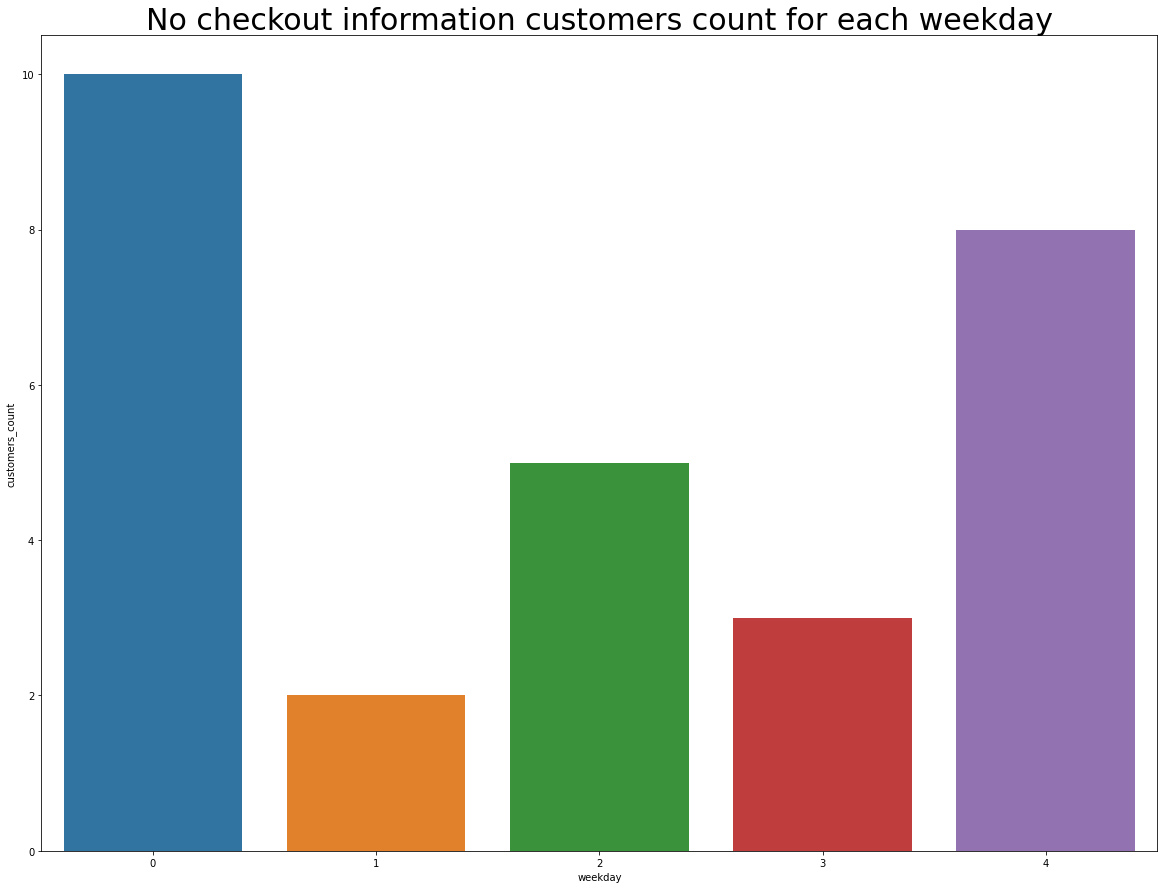

In [300]:

plt.figure(figsize=g_figsize)
sns.barplot(x=no_checkout_df['weekday'], y=no_checkout_df['customers_count']) \
.set_title("No checkout information customers count for each weekday", 
fontsize = g_title_fontsize)



In [301]:

all_days_df = pd.DataFrame()

for df in [mon_df, tue_df, wed_df, thu_df, fri_df]:
    all_days_df = all_days_df.append(add_missing_checkouts(df), ignore_index=True)

all_days_df

,timestamp,customer_no,location
0,2019-09-02 07:03:00,1,dairy
1,2019-09-02 07:03:00,2,dairy
2,2019-09-02 07:04:00,3,dairy
3,2019-09-02 07:04:00,4,dairy
4,2019-09-02 07:04:00,5,spices
...,...,...,...
24900,2019-09-06 21:50:00,1503,checkout
24901,2019-09-06 21:50:00,1505,checkout
24902,2019-09-06 21:49:00,1506,checkout
24903,2019-09-06 21:51:00,1509,checkout


In [302]:
mon_count=all_days_df.groupby("location")["customer_no"].count()
print("Total customer:", mon_count)


Total customer: location
checkout    7445
dairy       4679
drinks      3905
fruit       5122
spices      3754
Name: customer_no, dtype: int64


In [303]:
all_days_df["timestamp"] = pd.to_datetime(all_days_df["timestamp"])
all_days_df['hour'] = all_days_df['timestamp'].dt.hour
all_days_df['weekday'] = all_days_df['timestamp'].dt.weekday

all_days_df.tail()


,timestamp,customer_no,location,hour,weekday
24900,2019-09-06 21:50:00,1503,checkout,21,4
24901,2019-09-06 21:50:00,1505,checkout,21,4
24902,2019-09-06 21:49:00,1506,checkout,21,4
24903,2019-09-06 21:51:00,1509,checkout,21,4
24904,2019-09-06 21:51:00,1510,checkout,21,4


In [304]:
all_days_df['customer_no']

0           1
1           2
2           3
3           4
4           5
         ... 
24900    1503
24901    1505
24902    1506
24903    1509
24904    1510
Name: customer_no, Length: 24905, dtype: int64

In [305]:

max_customer_numbers = all_days_df.groupby(['weekday'])['customer_no'].max()

max_customer_numbers = max_customer_numbers.shift(1)
max_customer_numbers[0] = 0
max_customer_numbers = max_customer_numbers.astype(int).cumsum()



In [306]:


# all_days_df.set_index("timestamp", inplace=True)

customers_column = all_days_df.apply(lambda x : x['customer_no'] + max_customer_numbers[x['weekday']], axis=1)
customers_column.name = "customer_no"


In [307]:

all_days_df.update(customers_column)
all_days_df


,timestamp,customer_no,location,hour,weekday
0,2019-09-02 07:03:00,1,dairy,7,0
1,2019-09-02 07:03:00,2,dairy,7,0
2,2019-09-02 07:04:00,3,dairy,7,0
3,2019-09-02 07:04:00,4,dairy,7,0
4,2019-09-02 07:04:00,5,spices,7,0
...,...,...,...,...,...
24900,2019-09-06 21:50:00,7438,checkout,21,4
24901,2019-09-06 21:50:00,7440,checkout,21,4
24902,2019-09-06 21:49:00,7441,checkout,21,4
24903,2019-09-06 21:51:00,7444,checkout,21,4


In [308]:
all_days_df.groupby('customer_no').filter(lambda x : all(x['location'] != 'checkout')).value_counts()

Series([], dtype: int64)

Text(0.5, 1.0, 'Customer count for each location for entire week in each hour of a day')

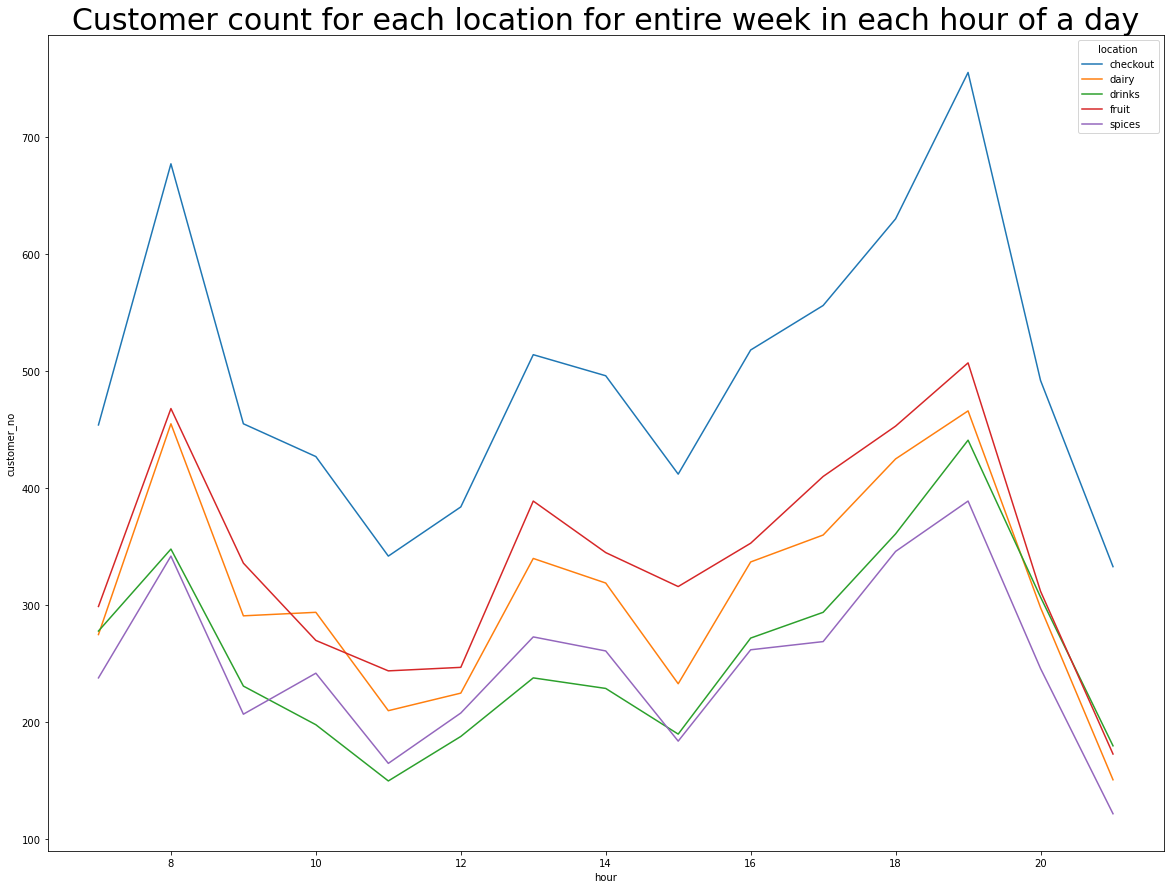

In [309]:
customer_no_per_section_hour = all_days_df.groupby(["location", "hour"])['customer_no'].count()
customer_no_per_section_hour = customer_no_per_section_hour.reset_index()
plt.figure(figsize=g_figsize)
sns.lineplot(data=customer_no_per_section_hour, x="hour", y="customer_no", hue="location")\
    .set_title("Customer count for each location for entire week in each hour of a day", 
    fontsize = g_title_fontsize)

In [310]:

all_days_df_cust_no= all_days_df.reset_index().groupby("customer_no")["timestamp"].agg(lambda x : np.max(x)-np.min(x))

def get_timespent(customer_no, df):
    return df.loc[customer_no]

all_days_df['total_timespent'] =  all_days_df['customer_no'].apply(get_timespent, args=(all_days_df_cust_no,))



In [311]:
all_days_df_cust_no= all_days_df.reset_index().groupby(["customer_no"]).first()
all_days_df_cust_no


,index,timestamp,location,hour,weekday,total_timespent
customer_no,,,,,,
1,0,2019-09-02 07:03:00,dairy,7,0,0 days 00:02:00
2,1,2019-09-02 07:03:00,dairy,7,0,0 days 00:03:00
3,2,2019-09-02 07:04:00,dairy,7,0,0 days 00:02:00
4,3,2019-09-02 07:04:00,dairy,7,0,0 days 00:04:00
5,4,2019-09-02 07:04:00,spices,7,0,0 days 00:01:00
...,...,...,...,...,...,...
7441,24884,2019-09-06 21:48:00,dairy,21,4,0 days 00:01:00
7442,24885,2019-09-06 21:48:00,dairy,21,4,0 days 00:02:00
7443,24886,2019-09-06 21:48:00,dairy,21,4,0 days 00:02:00


Text(0.5, 1.0, 'Customers count who go first to a particular location')

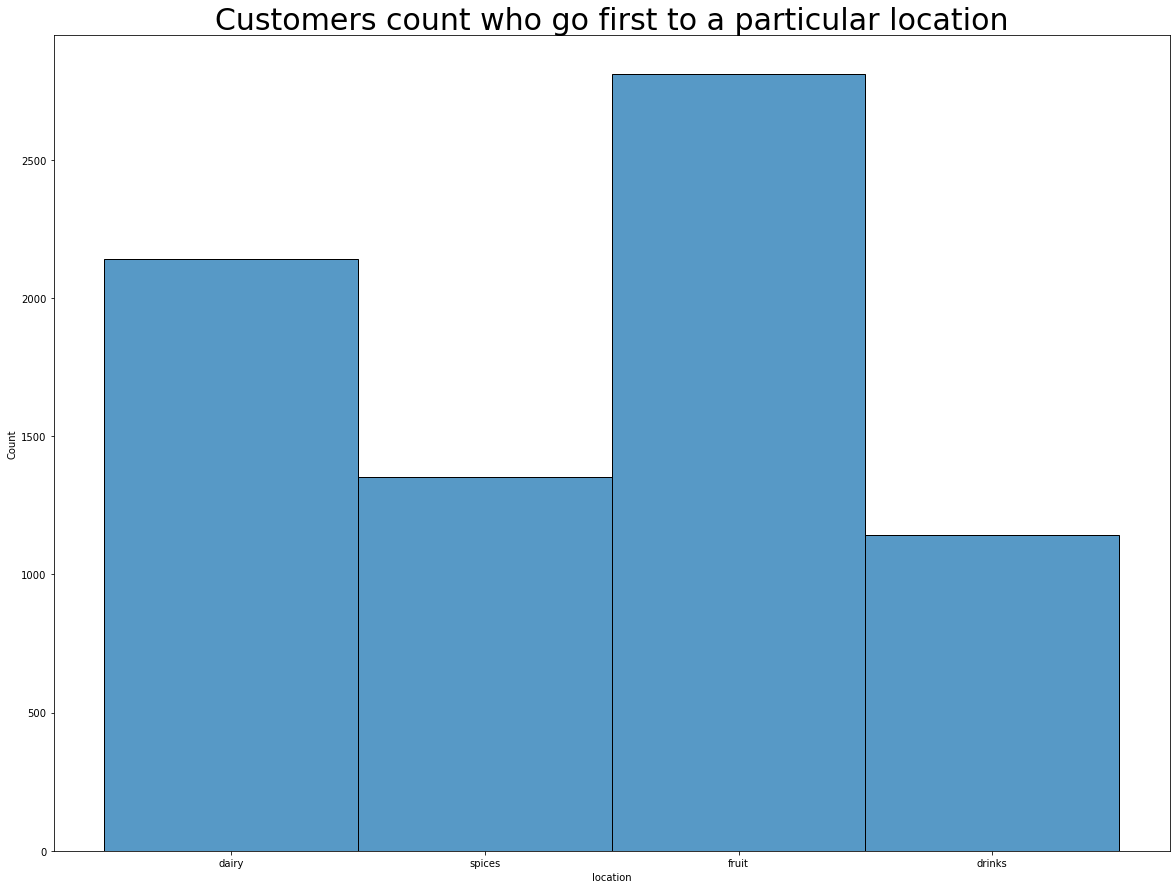

In [312]:
plt.figure(figsize=g_figsize)
sns.histplot(all_days_df_cust_no['location']).set_title("Customers count who go first to a particular location", 
fontsize = g_title_fontsize)

In [313]:
all_days_df_cust_no.loc[all_days_df_cust_no["location"] == 'checkout']['location'].count()

0

In [314]:
all_days_df['first_location'] =  all_days_df['customer_no'].apply(lambda x : all_days_df_cust_no.loc[x]['location'])
all_days_df

,timestamp,customer_no,location,hour,weekday,total_timespent,first_location
0,2019-09-02 07:03:00,1,dairy,7,0,0 days 00:02:00,dairy
1,2019-09-02 07:03:00,2,dairy,7,0,0 days 00:03:00,dairy
2,2019-09-02 07:04:00,3,dairy,7,0,0 days 00:02:00,dairy
3,2019-09-02 07:04:00,4,dairy,7,0,0 days 00:04:00,dairy
4,2019-09-02 07:04:00,5,spices,7,0,0 days 00:01:00,spices
...,...,...,...,...,...,...,...
24900,2019-09-06 21:50:00,7438,checkout,21,4,0 days 00:03:00,dairy
24901,2019-09-06 21:50:00,7440,checkout,21,4,0 days 00:02:00,fruit
24902,2019-09-06 21:49:00,7441,checkout,21,4,0 days 00:01:00,dairy
24903,2019-09-06 21:51:00,7444,checkout,21,4,0 days 00:01:00,drinks


Text(0.5, 1.0, 'Customers count for locations which are followed after first location')

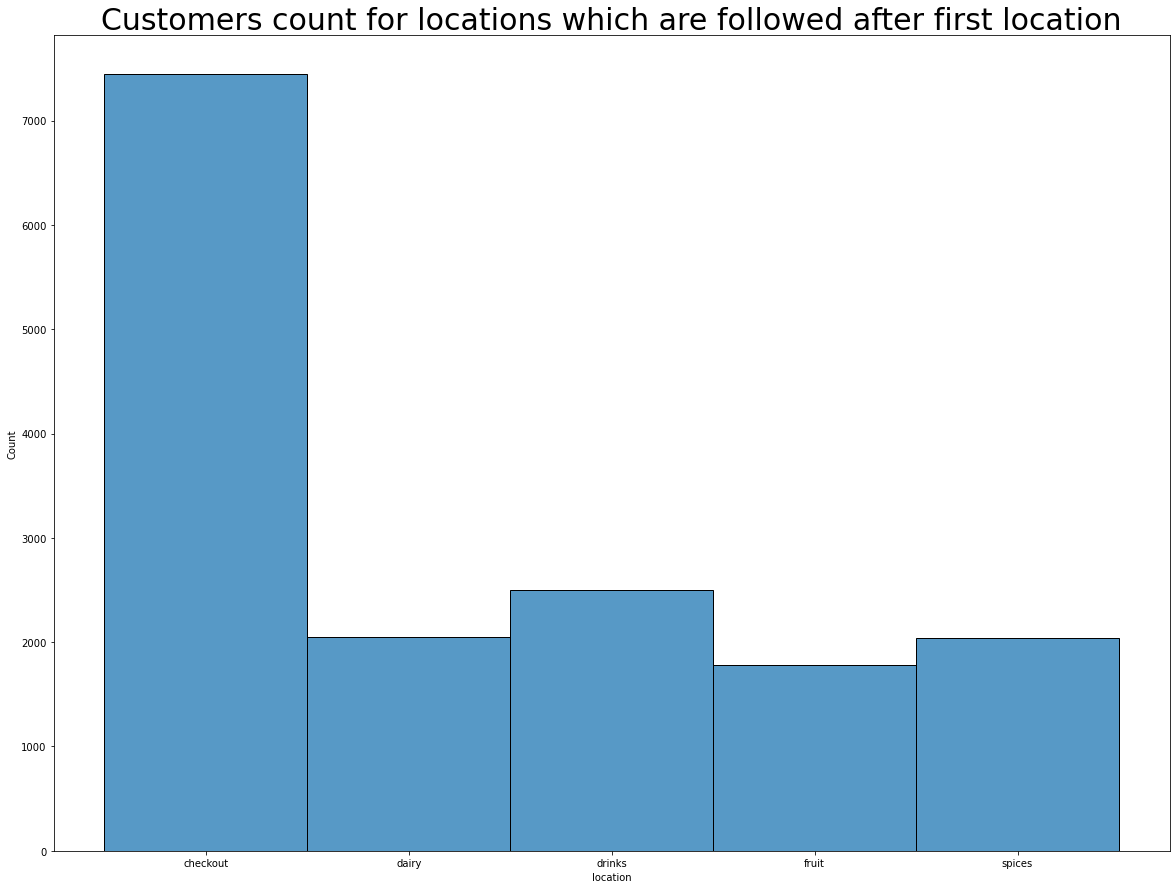

In [315]:
plt.figure(figsize=g_figsize)
sns.histplot(all_days_df.loc[all_days_df['first_location'] != all_days_df['location']]['location'])\
    .set_title("Customers count for locations which are followed after first location", 
    fontsize = g_title_fontsize)

Text(0.5, 1.0, 'Customers count for locations (not checkout) which are followed after first location')

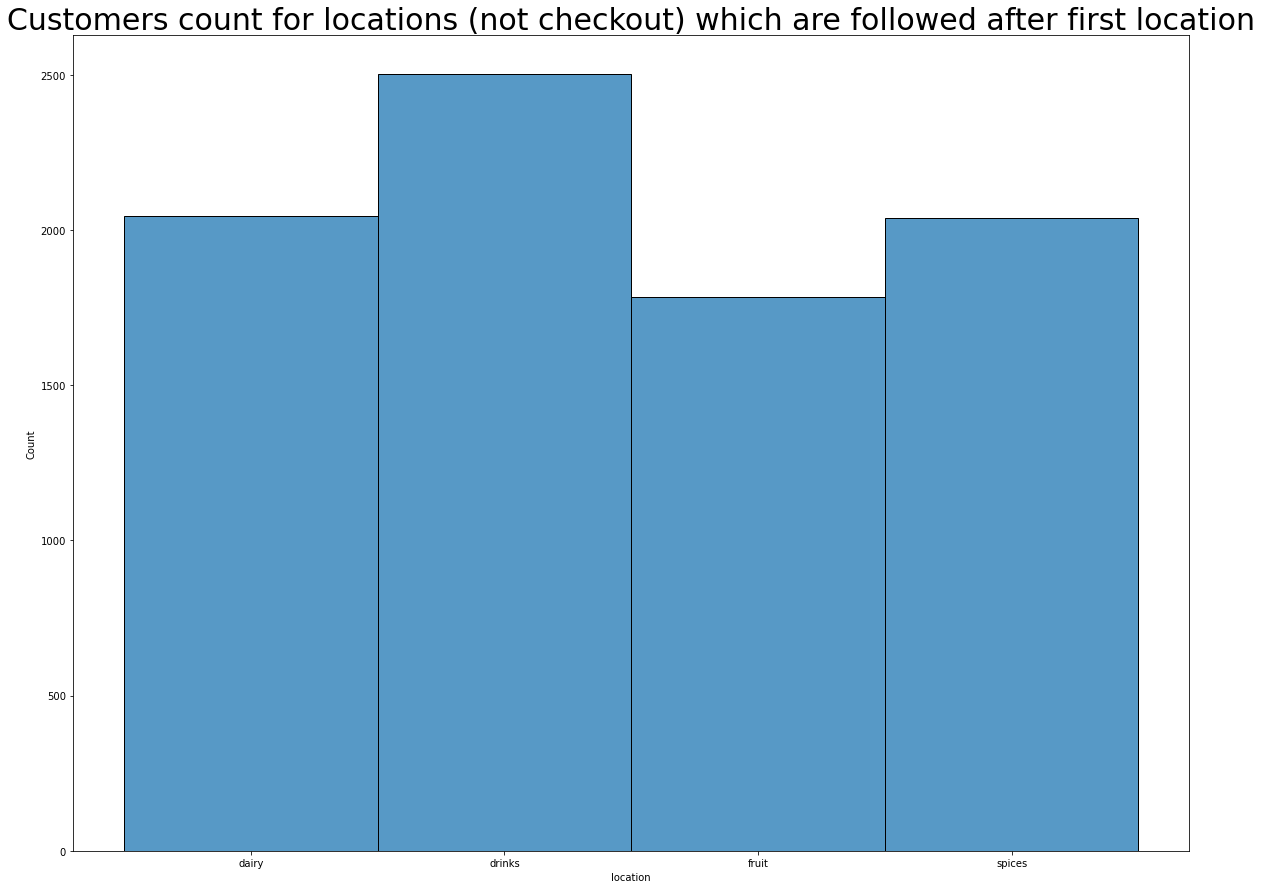

In [316]:
plt.figure(figsize=g_figsize)
sns.histplot(all_days_df.loc[(all_days_df['first_location'] != all_days_df['location']) & (all_days_df['location'] != 'checkout')]['location'])\
    .set_title("Customers count for locations (not checkout) which are followed after first location", 
    fontsize = g_title_fontsize)

In [317]:

revenue_per_minute = pd.DataFrame(data = {"revenue_per_min": [4.0, 3.0, 5.0, 6.0]}, index=['fruit', 'spices', 'dairy', 'drinks'])
revenue_per_minute.index.name = 'location'
revenue_per_minute


,revenue_per_min
location,
fruit,4.0
spices,3.0
dairy,5.0
drinks,6.0


In [318]:

customer_spent_df = customer_total_revenue(all_days_df, 1430, revenue_per_minute)
customer_spent_df

          location_time_spent
location                     
dairy                     2.0
fruit                    10.0


,location_time_spent
location,
dairy,10.0
fruit,40.0


In [321]:
get_customer_history(all_days_df, 1512)

DEBUG:root:               timestamp  customer_no  location  hour  weekday  \
5089 2019-09-03 07:38:00         1512     dairy     7        1   
5121 2019-09-03 07:45:00         1512     fruit     7        1   
5140 2019-09-03 07:48:00         1512  checkout     7        1   

     total_timespent first_location  
5089 0 days 00:10:00          dairy  
5121 0 days 00:10:00          dairy  
5140 0 days 00:10:00          dairy  
DEBUG:root:current time 2019-09-03 07:39:00
DEBUG:root:next time 2019-09-03 07:45:00
DEBUG:root:current time 2019-09-03 07:40:00
DEBUG:root:next time 2019-09-03 07:45:00
DEBUG:root:current time 2019-09-03 07:41:00
DEBUG:root:next time 2019-09-03 07:45:00
DEBUG:root:current time 2019-09-03 07:42:00
DEBUG:root:next time 2019-09-03 07:45:00
DEBUG:root:current time 2019-09-03 07:43:00
DEBUG:root:next time 2019-09-03 07:45:00
DEBUG:root:current time 2019-09-03 07:44:00
DEBUG:root:next time 2019-09-03 07:45:00
DEBUG:root:current time 2019-09-03 07:45:00
DEBUG:root:next ti

assigned delta
assigned next time step


['dairy',
 'dairy',
 'dairy',
 'dairy',
 'dairy',
 'dairy',
 'dairy',
 'fruit',
 'fruit',
 'fruit',
 'checkout']

In [320]:
# customer_transitions = get_customer_history(all_days_df, 1430)
# customer_transitions.reset_index(inplace=True)
# customer_transitions